# Spam Detection: Applying NLP and Random Forest for Text Message Classification
Machine Learning: Applications in Economic Research <br>
Ludwig-Maximilians University Munich <br>
submitted to: Thomas Fackler and Nadzeya Laurentsyeva <br>
submitted by Stanislas d'Orsetti, Hyeonu Kim and Sarah Dölger


## Introduction


Although the classic SMS text message has been overtaken in the past few years by the emergence of app-based messaging, SMS is still widely used. Whilst casual communication has moved to the likes of WhatsApp, iMessages or Telegram, SMS is still relied upon for more formal communication (e.g., two-stage identity verification, reminders to listen to your voicemail, confirmation of your COVID test timeslot). However, communication via SMS text message has not received the same default protection other forms of communication have seen. While email communication has a default spam filter regardless of which provider you use, a spam filter for text messages is not automatically enabled. The user must actively turn on spam protection, if this is even available on their phone. With smartphones constantly connected to the internet, saving passwords, and storing personal data, the threats that arise from clicking on a link in a false email are similar to those of following a link in a false text.

For our research project we will examine how well a simple spam filter works on text messages. Text messages have specific attributes that differentiate them from the conventional email and pose an interesting setting in which to test the effectiveness of different machine learning methods in classifying messages. Due to restrictions on the number of characters available per message, text messages usually consist of few words and frequently feature abbreviations. Also, the form of writing in text messages is in general less formal and more rife with personalized word use.  Accounting for these attributes is therefore essential for creating a spam filter specific for SMS messages. Therefore, this project will not only examine a Naïve Bayesian Classifier to determine whether a text is spam but also use Random Forest to examine what characteristics of a text message are informative about the type of message.




In [31]:
#pip install wordcloud
#pip install pydot
conda install -c anaconda graphviz

SyntaxError: invalid syntax (<ipython-input-31-ce2224c28f34>, line 3)

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
import nltk
from nltk import PorterStemmer
porter = PorterStemmer()
from nltk.tokenize import word_tokenize
from nltk import punkt
from nltk.corpus import stopwords


from nltk.stem.porter import *
from nltk.probability import FreqDist

# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import Image  

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import export_graphviz

import pydot


In [4]:
sms = pd.read_csv("spam.csv", engine='python')

## The Data

In order to test the applicability of a simple spam filter for text messages we use the SMS Spam Collection Dataset provided on Kaggle as a source for text messages. This dataset compiles spam and non-spam text message datasets from a variety of different sources. The main corpus of non-spam messages stems from a research dataset compiled at the University of Singapore. The messages were provided mainly by university students. The set of non-spam messages is extended by two other smaller sources. The spam messages predominately originate from a British online platform where users can indicate when they have received a spam message.

Overall, the dataset includes 4,825 non-spam messages and 747 spam messages. All messages are in English. An abstract can be seen below:


In [ ]:
sms

Each row in the data refers to one sent text message. The classification of the message into either spam or ham (non-spam) is stated in v1, whilst the content of that message is depicted in v2. The contents in columns three, four and five, referred to as “Unnamed: 2”, “Unnamed: 3” and “Unnamed: 4”, respectively, is not indicated clearly. Most of these columns do not contain any information. Filtering for those messages that do have informative content for these three columns, it appears that these are further text messages, although it is not always certain how these messages connect to the original text.

Message 710 is a good example where it is clear to see that the message was an addition to the original text.



In [7]:
sms_check = sms.loc[:,['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].dropna(how='all')
sms_check.head()

,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,"this wont even start........ Datz confidence..""",NaN,NaN


In [8]:
print(sms.iloc[710]['v2'])
print(sms.iloc[710]['Unnamed: 2'])

Height of Confidence: All the Aeronautics professors wer calld &amp; they wer askd 2 sit in an aeroplane. Aftr they sat they wer told dat the plane ws made by their students. Dey all hurried out of d plane.. Bt only 1 didnt move... He said:\if it is made by my students
this wont even start........ Datz confidence.."


In [9]:
sms_check.shape

(50, 3)

Because this is not always the case and only 50 messages in the dataset have informative contents for these columns, we exclude these columns from our analysis and focus only on the main text messages.

In [10]:
sms = sms.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
sms.columns = ['label','messages']
sms.head()

,label,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Descriptive Statistics

When examining the text messages in terms of their content, it quickly becomes clear that they cover a large scope of topics and have large differences in their writing style. Whilst some messages use “normal” vocabulary, many use abbreviations or slang that shorten the message. For example, the use of “u” instead of “you” and “2” instead of “to” are very common, but also “dat” is often used instead of “that”. The following word cloud demonstrates the most used words from all messages.

In [ ]:
text = ''.join(sms['messages'])
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Seeing as we have not processed the data in any way, it was to be expected that the most used words are unlikely to refer to a specific topic. Furthermore, our assumption that abbreviations are very common is correct. "u", "gt" or "ur" are amongst the most frequently used words. Unfortunately, we are unable to include numbers in the word cloud. Our guess is that number abbreviations would also be very common.

Dividing up the dataset into spam and ham messages, we find that a few words already appear indicative of a text being a spam message. For instance, the frequent usage of the words “free”, “call” and "txt" in spam texts fits to what one would generally expect. Also, many of the words relate to actions connected to winning a prize, such as "claim", "reply", "receive".

The word cloud for the non-spam messages does not appear very different from the cloud using all messages. This is on the one hand due to the fact that there are considerably more ham than spam messages, and on the other hand implies that ham messages contain less common topics. Therefore, the non-spam messages appear to have less content related words amongst the most frequently used words.



In [ ]:
ham = sms[sms['label'] == 'ham']
spam = sms[sms['label'] == 'spam']

In [ ]:
text = ''.join(spam['messages'])
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
text = ''.join(ham['messages'])
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Methodology



## Text Processing

When processing the text messages, we had to consider what characteristics of the actual message we want to capture. This is especially important when considering which stop words to remove and how to deal with the common use of abbreviations. If abbreviations are common for both spam and non-spam messaging, then these will be of little relevance when classifying a message. However, if only non-spam messages use certain abbreviations, then it could well be that our program uses these as their main way of differentiating between types of messages. Furthermore, we had to consider how to deal with capitalizations and punctuation, as these could also be indicative for the type of message. If key words such as "TEXT" or "FREE" are all capitalized it may be an indication that the message is spam, and therefore the capitalization scheme includes valuable information for distinguishing the type of message. For our baseline model we decided to include a large amount of pre-processing. This gives us an indication as to how well the program works by just examining the usage of words, disregarding all formatting of the text. We compare this baseline to a situation in which we preform less pre-processing.

The pre-processing includes removing stopwords, removing punctuation, turning all letters into lower cases.


In [ ]:
import string

stop = stopwords.words('english')

def txtprocess(messages):
    
    nopunc = [char for char in messages if char not in string.punctuation] 
    
    nopunc = ''.join(nopunc)

    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in stop])

In [ ]:
sms['processed'] = sms.messages.apply(txtprocess)
sms.head()

After processing the most common words for ham and spam messages are still very similar compared to the non-processed texts.

In [ ]:
#splitting the dataset into ham and spam

ham = sms[sms['label'] == 'ham']
spam = sms[sms['label'] == 'spam']

In [ ]:
word_spam = ''.join(spam['processed'])
word_ham = ''.join(ham['processed'])
tokenized_word_spam=word_tokenize(word_spam)
tokenized_word_ham=word_tokenize(word_ham)

stopword = set(STOPWORDS)

In [ ]:
#Counting the number of times the most frequent words in processed ham and spam messages are used
fdist_spam = FreqDist(tokenized_word_spam)
fdist_ham = FreqDist(tokenized_word_ham)

In [ ]:
fdist_spam.plot(30,cumulative=False, title = 'most used words in processed spam messages')
plt.show()

In [ ]:
fdist_ham.plot(30,cumulative=False, title = 'most used words in processed ham messages')
plt.show()

In order to apply a Naïve Bayesian model, we tokenize the text. In our baseline model we only include words that consist of only letters and are between 3-20 characters long. Furthermore, we disregard tokens that are not mentioned in more than three different texts. This prevents for example, unintentionally misspelled words from being included. Setting min_df=3 reduces the number of tokens from 7945 without any restrictions, to 2277 with restriction. As we want to avoid overfitting our model, we set a minimum.

Setting a maximum on how many text messages use specific words does not have an impact on the tokens in this dataset. This is due to the fact that the most frequently used words are already filtered out: words shorter than three characters and stopwords. Only when the max_df measure is set to below 5% does this have an effect on the number of tokens. We therefore do not include an upper bound to the frequency of used words.

In order to compare the accuracy of our baseline model to a model using less processed data, we also tokenize the text messages in their original format; we do not control for the length of words, the use of numbers or symbols, the capitalization, nor do we exclude stopwords. This leaves us with 3332 tokens.


In [ ]:
#Tokenizing Processed Messages
rx = '[a-zA-Z]{3,20}'
cv = CountVectorizer(max_df=1.0, min_df=3, max_features=10000, stop_words='english', token_pattern = rx)

cvf = cv.fit_transform(sms["processed"])
print(cv.get_feature_names())
print(cvf.toarray().shape)

In [ ]:
#Tokanizing non-processed Messages
cv_np = CountVectorizer(lowercase=False, max_df=1.0 , min_df=3, max_features=10000)

cv_npf = cv_np.fit_transform(sms["messages"])
print(cv_np.get_feature_names())
print(cv_npf.toarray().shape)

 # Modeling - using Naive Bayesian Classification

The first method we will test as a spam filter is a Naïve Bayesian classifier. Controlling for the amount of text processing, we will be able to tell how indicative word usage is for classifying text messages into spam or non-spam.

In order to run a Naïve Bayesian model, we firstly generate a vector that labels a message with the indicator 1 if the message is spam.


## Baseline - Processed Texts:

Our baseline model uses the fully processed tokenized messages. Splitting our sample into 80% training and 20% test, we obtain an accuracy rate of classifying a text message correctly of around 97.8%. This is a very high accuracy rate. Examining the confusion matrix we observe that 11 non-spam messages were wrongly classified as spam, and 14 spam messages were wrongly classified as normal texts. For the spam messages this is a rate of false negatives of 9.3% and larger than we would like.

In [ ]:
x = cv.fit_transform(sms["processed"])
y = sms['label']

In [ ]:
# split sets into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
classifier = MultinomialNB().fit(x_train, y_train)

In [ ]:
pred = classifier.predict(x_test)
cm_p = confusion_matrix(y_test, pred)
acc_p = accuracy_score(y_test, pred)
print(classification_report(y_test, pred))
print()
print('Confusion Matrix:\n',cm_p)
print()
print('Accuracy : ', acc_p)

## Non-Processed Texts:

When using non-processed text messages, we obtain slightly higher accuracy of 98.6%. This comes from an improvement in classifying non-spam messages. With no processing only 3 out of 965 non spam text messages are wrongly classified as spam. The number of false negatives for spam messages reduces by one. This indicates that the extra information the algorithm received from the inclusion of numbers, shorter words and capitalizations was useful in determining non-spam rather than spam texts. This also indicates that the format of the text contains some useful information for the classification.

In [ ]:
a = cv_np.fit_transform(sms["messages"])
b = sms['label']

In [ ]:
# split sets into train/test
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=0.2, random_state=42)

In [ ]:
classifier_np = MultinomialNB().fit(a_train, b_train)

In [ ]:
pred_np = classifier_np.predict(a_test)
cm_np = confusion_matrix(b_test, pred_np)
acc_np = accuracy_score(b_test, pred_np)

print(classification_report(b_test, pred_np))
print()
print('Confusion Matrix:\n',cm_np)
print()
print('Accuracy : ',acc_np)

# Modeling - Using TF-idf

As a comparison we test a spam filter using a TF-IDF vectorizer. This method puts higher weights on words which are characteristic for a particular text. Our hypothesis is that words indicative of a spam message such as “FREE” or “win” will receive higher weightings than words such as “will”, “go” or “know” which are amongst the most common words from non-spam messages. Although the term frequency should be low for all words in all documents due to how short each text message is, the inverse document frequency should weight how rare words are across all texts. Given that the number of spam messages is considerably lower than the number of ham messages, this should be giving higher weighting to words indicative of spam messages by design. Our hypothesis is that using TF-IDF will improve the rate with which spam messages are recognized.

## Processed Texts

The results we obtain contradict our hypothesis. The model is not better at predicting spam messages, it is in fact worse. Although the accuracy is very similar to the accuracy using the Naive Bayes algorithm, the rate at which spam messages are wrongly classified as non-spam has more than doubled. On the up side, the algorithm has greatly improved in correctly classifying non-spam messages. Only one ham message from the test set was wrongly marked as spam.

In [ ]:
rx = '[a-zA-Z]{3,20}'
tfid = TfidfVectorizer(max_df=1.0, min_df=3, max_features=10000, stop_words='english', token_pattern = rx)
tfidf = tfid.fit_transform(sms["processed"])
#print(tfid.get_feature_names())
#print(tfidf.toarray().shape)

In [ ]:
c = tfidf
d = sms['label']

In [ ]:
c_train, c_test, d_train, d_test = train_test_split(c, d, test_size=0.2, random_state=42)

In [ ]:
classifier_tf = MultinomialNB().fit(c_train, d_train)

In [ ]:
pred_tf = classifier_tf.predict(c_test)
cm_tf = confusion_matrix(d_test, pred_tf)
acc_tf = accuracy_score(d_test, pred_tf)

print(classification_report(d_test, pred_tf))
print()
print('Confusion Matrix:\n',cm_tf)
print()
print('Accuracy : ', acc_tf)

## Non-Processed Texts

When using non-processed text message data, the results do not change compared to the processed text model. The results are similarly bad. 19.3% of the spam messages are wrongly classified.

In [ ]:
tfid_2 = TfidfVectorizer(lowercase=False, max_df=1.0, min_df=3, max_features=10000)
tfidf_2 = tfid_2.fit_transform(sms["messages"])

In [ ]:
e = tfidf_2
f = sms['label']

In [ ]:
e_train, e_test, f_train, f_test = train_test_split(e, f, test_size=0.2, random_state=42)

In [ ]:
classifier_tfnp = MultinomialNB().fit(e_train, f_train)

In [ ]:
pred_tfnp = classifier_tfnp.predict(e_test)
cm_tfnp = confusion_matrix(f_test, pred_tfnp)
acc_tfnp = accuracy_score(f_test, pred_tfnp)

print(classification_report(f_test, pred_tfnp))
print()
print('Confusion Matrix:\n',cm_tfnp)
print()
print('Accuracy : ',acc_tfnp)

The question that arises is how come the TF-IDF model preforms so poorly in predicting spam messages correctly. One possibility is that our hypothesis that words indicative of spam texts receive higher weights is not correct. It could be that a large number of words appearing only rarely in non-spam messages because they are for example used by only few individuals, concern a very specific topic or are misspelled a few times, receive the highest weightings. Words that are more common in spam messages could receive a low weighting because compared to these individualized words from non-spam messages they appear relatively often. Testing for a model in which we increase the minimum number of different text messages that need to use a specific word, we find that results improve somewhat, but are still worse than our baseline Naïve Bayesian model.

## Comparing Results

Comparing all four of the above models we find that the Naïve Bayesian classifier using non-processed text messages is most reliable for classifying spam and ham messages. Not only does is have the highest accuracy, but it also produces the least false classifications for spam messages. In our opinion correctly filtering spam is more relevant than correctly classifying non-spam. That both Naïve Bayes and TF-IDF work better using non-processed texts raises the question to what extent the autographic characteristics of the messages aid the algorithm in the classification. We therefore propose a method by which the classification process will be independent of the actual word usage but be solely based on the format of the text.

In [27]:
categories = ['Ham','Spam']

def confmat(result,Title,Acc):
    fig, ax = plt.subplots()
    im = ax.imshow(result, cmap="Pastel1")

    ax.set_xticks(np.arange(len(categories)))
    ax.set_yticks(np.arange(len(categories)))

    ax.set_xticklabels(categories)
    ax.set_yticklabels(categories)
    
    for i in range(len(categories)):
        for j in range(len(categories)):
            text = ax.text(j, i, result[i, j], ha="center", va="center")
    ax.set_title(Title)
    accuracy = 'Accuracy : {}%'.format(round(Acc*100,2))
    ax.set_xlabel(accuracy)
    fig.tight_layout()
    plt.show()

In [ ]:
confmat(cm_p,'Confusion Matrix for processed texts',acc_p)
confmat(cm_np,'Confusion Matrix for non-processed texts',acc_np)
confmat(cm_tf,'Confusion Matrix for processed texts - using tfidf,',acc_tf)
confmat(cm_tfnp,'Confusion Matrix for non-processed texts - using tfidf',acc_tfnp)

# Modeling - Using Random Forest

When examining the text messages in terms of the format of the text rather than the word content we find numerous features which we believe distinguish spam from ham messages. Therefore, we think that we can create a spam filter which uses these features. Indeed, instead of taking into account the message and develop a natural language processing tools, we can use message characteristic and train machine learning methods on these features, without taking the content of the message into account.

In the following exercise, we append three features to each message: the length, the relative number of digits and the number of capital letters. We then train a random forest algorithm. This algorithm builds several classification trees on different subdata sets, by selecting randomly both raws and features, to avoid overfitting.

We believe that this algorithm could be the best option for our application because we have a quite low number of different features and a relatively small dataset. More complex machine learning algorithms such as neural network would have probably been unfeasible.


In [11]:
#Generting a variable that captures the length of a message in terms of the number of characters.

sms['length'] = sms['messages'].apply(len)

In [12]:
#Generating a variable that counts the number of capital letters.

def capital_letter(message):
  return sum(1 for c in message if c.isupper())

sms['capital'] = sms['messages'].apply(capital_letter)

In [13]:
# We create an index of the relative number of digits in a message.

def count(messages):
  numbers = sum(c.isdigit() for c in messages) + 1 
  letters = sum(c.isalpha() for c in messages) + 1 
  spaces  = sum(c.isspace() for c in messages)
  others  = len(messages) - numbers - letters - spaces
  return numbers/(letters+numbers+spaces+others)

sms['relative_number_of_digits'] = sms['messages'].apply(count)

In [14]:
sms.head()

,label,messages,length,capital,relative_number_of_digits
0,ham,"Go until jurong point, crazy.. Available only ...",111,3,0.009009
1,ham,Ok lar... Joking wif u oni...,29,2,0.034483
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,10,0.167742
3,ham,U dun say so early hor... U c already then say...,49,2,0.020408
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,0.016393


Before implementing the random forest, we will firstly examine how well the three chosen features are distinctive for spam messages.

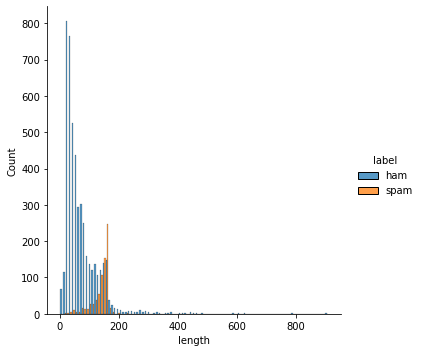

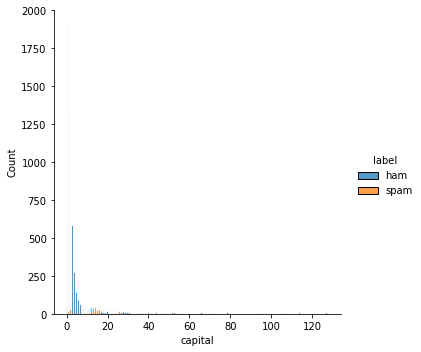

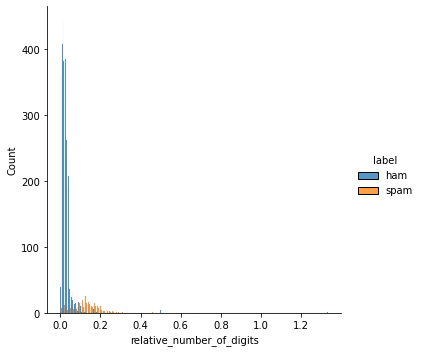

In [15]:
sns.displot(sms, x='length',hue='label', multiple = "dodge")
sns.displot(sms, x='capital',hue='label', multiple = "dodge")
sns.displot(sms, x='relative_number_of_digits',hue='label', multiple = "dodge")

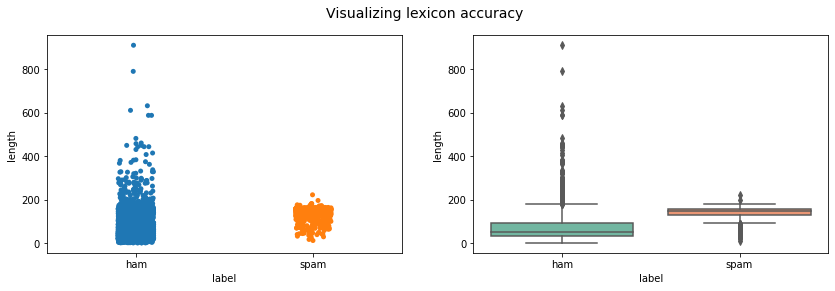

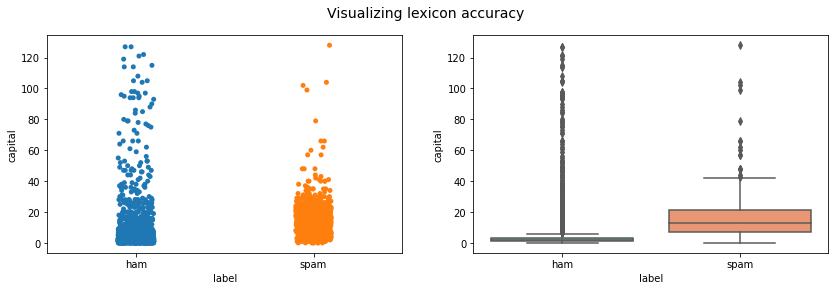

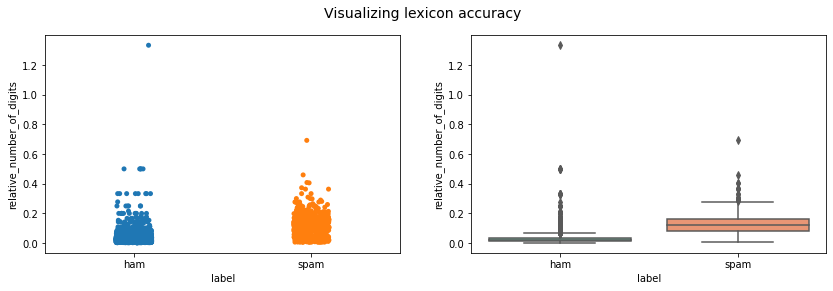

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='label', y="length", data=sms, ax=ax1)
bp = sns.boxplot(x='label', y="length", data=sms, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing lexicon accuracy', fontsize=14)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='label', y="capital", data=sms, ax=ax1)
bp = sns.boxplot(x='label', y="capital", data=sms, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing lexicon accuracy', fontsize=14)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='label', y="relative_number_of_digits", data=sms, ax=ax1)
bp = sns.boxplot(x='label', y="relative_number_of_digits", data=sms, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing lexicon accuracy', fontsize=14)

Overall, there seem to be clear distinctions between the two labels for the three features we have chosen. For all three features the distributions of the characteristics are different between ham and spam texts. In general, we find that non-spam messages have lower averages for all of the characteristics, but also a larger number of outliers.

Take for example the length feature: The average spam message contains 138 characters, whilst the average non-spam message contains only 71 characters. Also, the distribution of the message lengths is very different. Non-spam texts are usually very short, with more than 75% of the messages being below 100 characters and about 50% of the messages being below 50 characters. However, there are a few ham texts which are considerably longer than all other messages. On the spam side, messages are mainly between 130 and 150 characters long, with few messages being very short and no message being very long. It is very rare that a spam message exceeds the standardized text length of 160 characters.

In general, it is a bit confusing that some text messages exceed the length of 160 characters for one text message. One possible explanation is that messages exceeding the 160-character limit were sent using multiple texts but are considered in the dataset as only one message. We are unable to verify if this is the case.


In [17]:
sms[['length', 'label']].groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.021347  58.014768   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.429719  29.049857  13.0  132.0  149.0  157.0  223.0

Having demonstrated that the differences in our chosen characteristics are substantial, we now move on to training our random forest algorithm. This algorithm is going to train several decision trees and select randomly both raws and features in order to find the best tree and to avoid overfitting.

In [18]:
# We first create a dummy for the label
label_dummies = pd.concat([pd.get_dummies(sms['label'])['spam'], sms[['length','capital','relative_number_of_digits']]], axis=1)

In [19]:
label_dummies

,spam,length,capital,relative_number_of_digits
0,0,111,3,0.009009
1,0,29,2,0.034483
2,1,155,10,0.167742
3,0,49,2,0.020408
4,0,61,2,0.016393
...,...,...,...,...
5567,1,160,9,0.137500
5568,0,37,1,0.027027
5569,0,57,2,0.017544
5570,0,125,2,0.008000


In [20]:
#We create a list with our features and an array for the labels (spam) and for the feature. 
labels = np.array(label_dummies['spam'])
features= label_dummies.drop('spam', axis = 1)
feature_list = list(features.columns)
features = np.array(features)


Now that we have our dataset ready, we split it into train data set and test data set with the library sklearn.

In [21]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [22]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (4457, 3)
Training Labels Shape: (4457,)
Testing Features Shape: (1115, 3)
Testing Labels Shape: (1115,)


In [23]:
#TRAIN
rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
rfc.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [24]:
# TEST
y_pred = rfc.predict(test_features)
print(rfc.predict(test_features[:100]))

[0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


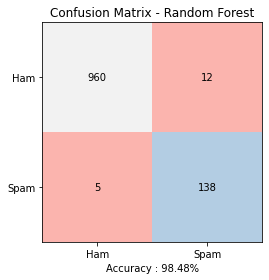

Accuracy: 0.9847533632286996


In [28]:
# Result
Accuracy_k = accuracy_score(y_pred, test_labels)
confmat(confusion_matrix(y_pred, test_labels),'Confusion Matrix - Random Forest', Accuracy_k)
print('Accuracy:', Accuracy_k)

Using our random forest we get very good results for the accuracy (around 98.5%). Also, the confussion matrix shows that the model classifies only 5 spam messages wrongly as non-spam, a rate of around 3.5%.

To better understand what happened, we would like to see what the decision tree actually looks like. 


In [ ]:
tree = rfc.estimators_[5]
export_graphviz(tree, out_file='tree.dot', 
                feature_names = feature_list,
                rounded = True, 
                precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
Image(graph.create_png())

To better understand what features are important at the different nodes, we examine a tree restricted to 3 layers.  

In [ ]:
rfc_small = RandomForestClassifier(n_estimators=1000, max_depth = 3)
rfc_small.fit(train_features, train_labels)
tree_small = rfc_small.estimators_[5]
export_graphviz(tree_small, out_file='small_tree.dot', 
                feature_names = feature_list,
                rounded = True, 
                precision = 1)
(graph_small, ) = pydot.graph_from_dot_file('small_tree.dot')
Image(graph_small.create_png())

In the tree with 3 layers, the number of capital letters does not seem to play a big role because it is not used in the classification process. In order to examine if this is also the case for out unrestrained tree, we investigate how important each of our three features are for the classification of the baseline tree. 

In [26]:
importances = list(rfc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: relative_number_of_digits Importance: 0.5
Variable: capital              Importance: 0.26
Variable: length               Importance: 0.23


[None, None, None]

We find that the number of digits and the number of capital letters are more important than the length of the messages for the classification process. The difference in importance between the number of capital letters and the length is not very large though.

We will train a new random forest algorithm using only the two most important variables: relative_number_of_digits and capital.

In [29]:
# New random forest with only the two most important variables
rfc_most_important = RandomForestClassifier(n_estimators= 1000, random_state=42)
important_indices = [feature_list.index('relative_number_of_digits'), feature_list.index('capital')]

#TRAIN
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

rfc_most_important.fit(train_important, train_labels)

#TEST
y_pred = rfc_most_important.predict(test_important)


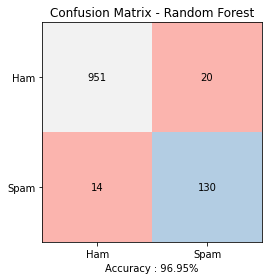

Accuracy: 0.9695067264573991


In [30]:
# Result
Accuracy_k = accuracy_score(y_pred, test_labels)
confmat(confusion_matrix(y_pred, test_labels),'Confusion Matrix - Random Forest', Accuracy_k)
print('Accuracy:', Accuracy_k)

Leaving out one of the features reduces the accuracy of the model to 97% and makes it considerably more difficult for the algorithm to determine spam messages correctly. Adding the length as a feature therefore adds 1.5% onto the accuracy and also decreased the number of wrongly classified ham and spam messages by 9 and 8, respectively.

# Comparision

Comparing the performance of all our models, we find that all models have similarly high accuracy rates. The Naïve Bayesian classifier without text processing and the baseline random forest lead to the best results. In both cases the accuracy is around 98.5%. Comparing only the NLP models we find that in both cases the algorithm preforms better when using non-processed texts than when using processed text data. This underlines that features such as capitalizations and the use of numbers are informative indicators for the classification process.

The largest difference between the NLP and the Random Forest models is how well they perform at correctly identifying spam and ham messages. Whilst Naïve Bayes and TF-IDF are better at correctly classifying ham messages, the Random Forest makes less mistakes when classifying spam. We predict that this difference comes from the distribution of the features in the regression tree approach. The features for the spam messages display considerably less variance compared to the ham messages. We believe that this enables the algorithm to identify spam with higher certainty.

If we were to choose our most successful spam filter, we would need to consider which outcome we prefer: capturing all spam messages and running the risk of falsely classifying ham as spam, or letting more spam messages escape our filter. On the one hand, it could be extremely frustrating to not receive normal text messages because these were mistakenly filtered as spam and one may be prepared to receive a spam messages once in a while in order to avoid this. On the other hand, the fundamental idea of a spam filter is to correctly catch all spam messages. Drawing on our experiences with spam filters for emails, we presume that the industry standard is to avoid false positives at the cost of an occasional spam email passing through the filter. We would therefore be inclined to propose a natural language-based spam filter.

| Method                | Naive Bayes: Processed text | Naive Bayes: Non-processed text  | TF-idf: Processed text | TF-idf: Non-processed text   | Random Forest      | Random Forest, keeping only the 2 most important features |
|-----------------------|-----------------------------|---------------------|---------------------------|--------------------|--------------------|-----------------------------------------------------------|
| Accuracy              | 0.9775784753363229          | 0.9856502242152466  | 0.9713004484304932        | 0.9730941704035875 | 0.9847533632286996 | 0.9695067264573991                                        |
| False Positive (spam) | 11                          | 3                   | 1                         | 1                  | 12                 | 20                                                        |
| False Negative  (ham)      | 14                          | 13                  | 31                        | 29                 | 5                  | 14                                                         |

(We refer to a false positive when a ham message is wrongly marked as spam and to a false negative when a spam message is wrongly marked as ham.)

# Discussion

This project leaves ample space for improvements and extensions, a few of which we will now address. On the side of improvements, it would strengthen the validity of our results if we presented a larger variety of model specifications as well as included a stronger validation process. There are many ways for us to adjust the natural language processing models via variations in the data cleaning process as well as in our choice of parameters in the vectorization procedure. In order to keep the results comparable though we decided to fix the vectorization parameters and focus on adjusting the amount of text processing. For this we present our upper and our lower bound: full processing and no processing. Nevertheless, varying the model’s parameters, such as setting a maximum number of times a word may appear, present interesting insights into the data. As previously mentioned, only when the maximum is set below 10% does it start to become binding. This not only reflects the fact that text messages contain few words, but that the word choice between messages varies strongly. Not even abbreviations such as “ur” are used in more than 5% of the messages.

In terms of strengthening the internal validity our NLP models, preforming a larger number of out-of-sample tests would help determine the consistency of our findings. A k-fold cross validation would be an ideal method by which to reliably capture the performance of our models. However, we are fairly constrained in the choice of our test and training sets due to the amount of data points available. A cross validation will only strengthen our analysis if we generate random subsamples using replacement.

For the Random Forest we found that we were slightly constrained by the amount of data available to use. On the one hand, including a larger set of characteristics would be interesting and would also allow us to determine the most informative features of the text messages more precisely. Nevertheless, we find that using only two features already returns good results. On the other hand, adjusting the model parameters would be the natural next step when using random forests. We decided to utilize a baseline, default model as the aim of the exercise was not to taming the trees, but to see if it were possible to find another method by which to filter spam, other than natural language processing. When including some constraints, such as a stopping rule or a maximum number of nodes, we found that the overall accuracy of the model was equally high as in the baseline, but that the accuracy with which spam and ham messages were classified shifted. The algorithm became more successful in predicting spam messages and less precise when predicting non-spam.

Whilst there are many ways in which this analysis could be expanded and extended there are caveats which we are unable to correct for. The main problem which we face is the constraint of our dataset. We will therefore discuss some of the data issues and how these potentially impact our results.

Firstly, there are considerably more non-spam messages in our dataset than spam message. This is externally valid but means that we lack spam messages with which to train our algorithm. It is therefore of little surprise that the Naïve Bayesian and the TF-IDF models are better trained at recognizing non-spam text.

Secondly, the sources of the data could impact our results. The authors of the dataset refer in their description to the difficulty of compiling the text messages. Very few sources for real text messages are available, and nearly no source collects spam messages. The authors therefore mix sources, which means that the spam and the ham messages do not originate from the same set of individuals. This would in general not necessarily be a problem, however in this case, the geographics and the demographics of the text message sources are very distinct. The ham messages mainly stem from university students in Singapore and the spam messages from the United Kingdom. It can be imagined that there are subtle differences in the vocabulary used in these two countries which could affect how well an NLP algorithm can distinguish between spam and ham. If such a difference does exist, we hypothesis that this improves our accuracy rate, and that accuracy may be slightly lower if we had spam and ham data for the same country. Also, the demographic characteristic of the data could be impacting the results. Our personal experience shows use that students generally use a different language for text messaging than older generations. They are less concerned with correct spelling or grammar, frequently use abbreviations, and include slang into their writing. This could lead to a clear distinction between spam and ham messages, as spam messages are more likely to use “normal” language. If we were to include more messages from older generations, we believe that this could drive down our accuracy. No doubt some students would be happy to classify text messages from their parents as spam.

A third, more general data concern is selection bias. It is not clear what the conditions are for a message to be classified as spam. Does this only include messages from phone numbers unknown to the receiver publicizing a product or asking for participation in a prize draw or does this also include promotional messages from companies which gained fair access to the phone number? Seeing as the spam message data was collected from a site on which individuals can post when they have received a spam message, the dataset is influenced by individual beliefs of what constitutes spam. It is possible that the individuals who post on this website have very strong opinions on receiving unwanted messages. Furthermore, we believe that more subtle forms of spam could be underrepresented in the data. Recipients may not directly recognize a message as spam but may believe that somebody texted the wrong number by mistake. Given the difficulty with which the authors of the dataset collect data on spam messages, it appears that a selection bias is not only a concern for this dataset but also for the compilation of future spam text datasets. We are dependent on what others believe are spam messages.


# Conclusion

This applied project examines how well three different machine learning methods can be used as a spam filter for text messages. We compare two natural language processing approaches, Naïve Bayesian and TF-IDF, and a regression tree classification. The natural language processing methods focus mainly on the word content of the text messages, whilst the regression trees utilize differences in text message features to determine spam. Overall, we find that all three models deliver similar results in terms of out-of-sample accuracy. However, when examining how well NLP and Random Forest correctly identify spam and ham respectively, we find that the models provide different results. The NLP models are comparatively better at specifying non-spam messages, whilst the Random Forest is relatively better at filtering spam. We connect this difference to the characteristics of the data used by the respective models.

The exercise presented here is by no means a complete representation of the machine learning methods that can be applied as a spam filter but gives a first indication of what methods could viably be implemented. The most noteworthy result of the analysis is that the word content of a text message is no more indicative of the type of message than the format of the text. We believe that this is special for text message data due to the unique characteristics of texts.

Whilst text messaging for personal communication has been displaced in recent years by app-based messaging, many digitalization processes in banks, public services or healthcare rely on text messaging. We are increasingly providing companies access to our private phone numbers, allowing them to send us warnings for train delays or reminders to renew a subscription, increasing the risk of numbers being diverted to unwanted third parties. This raises the importance of creating a reliable spam filter for text messaging. However, for this to be possible the gaps in the data available for training spam filters need to be filled.
